# MRI and Alzheimers 
## Predict Dementia Using Longitudinal MRI Data in Nondemented and Demented Older Adults 
### Huiyu (Shirley) Sun

## Import Dataset

#### Data Features (151 subjects)
- Subject ID
- MRI ID
- Visit
- MR Delay
###### Demographic
- M/F
- Hand - Right hand
- Age - (60 - 98)
- EDUC (years)
- SES - Socioeconomic status 1: less than high school grad., 2: high school grad., 3: some college, 4: college grad., 5: beyond college.
###### Clinical
- MMSE - Mini-Mental State Examination (commonly used set of questions for screening cognitive function; 0-10 = Severe, 10-20 = Moderate; 20-25 = Mild; 25-30 = Questionably Significant)
- CDR - Clinical Dementia Rating (CDR; 0 = nondemented; 0.5 = very mild dementia; 1 = mild dementia; 2 = moderate dementia) (Morris, 1993). All participants with dementia (CDR >0) were diagnosed with probable AD.
###### Derived anatomic volumes
- eTIV - Estimated total intracranial volume
- nWBV - Normalized whole brain volume
- ASF - Atlas scaling factor
###### Response to be predicted
- Group - Demented, Nondemented, Converted

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

mri_long = pd.read_csv('oasis_longitudinal.csv', sep = ',')
mri_long.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [2]:
# closer look to the score and labels, responses
# they are highly correlated, so I only keep one 
# here I choose Group as response, because CDR is more useful for early detection
# 0-2 CDR has the probability of being Demented but only 0.0 and 0.5 can be treated as Nondemented
# we cannot predict converted, so we will convert converted to Demented later
mri_long.groupby(['CDR', 'Group']).size().unstack()

Group,Converted,Demented,Nondemented
CDR,,,
0.0,18.0,NaN,188.0
0.5,19.0,102.0,2.0
1.0,NaN,41.0,NaN
2.0,NaN,3.0,NaN


In [3]:
# missing values
# I'll remove the missing values because they are correlated with age and education
# hard to impute
mri_long.isnull().sum()

Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay       0
M/F            0
Hand           0
Age            0
EDUC           0
SES           19
MMSE           2
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64

## Pre-Process

In [4]:
# Drop the trivial/unrelated predictors
df = mri_long
df = df.drop(['Subject ID', 'MRI ID', 'Hand'], axis = 1)
display(df.head(), df.shape)

,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,Nondemented,1,0,M,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,Nondemented,2,457,M,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,Demented,1,0,M,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,Demented,2,560,M,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,Demented,3,1895,M,80,12,NaN,22.0,0.5,1698,0.701,1.034


(373, 12)

In [5]:
# Feature engineering (not sure whether it is useful, but it proved to be a unnecessary step)
# MMSE Scores Mini-Mental State Examination - Ordinal
# Ref: https://www.heartandstroke.ca/-/media/pdf-files/canada/clinical-update/allen-huang-cognitive-screening-toolkit.ashx?la=en&hash=631B35521724C28268D0C2130D07A401E33CDBB0
# 25-30 (Questionably significant); 20-25 (Mild); 10-20 (Moderate); 0-10 (Severe)
def mmse_group(col):
    if col <= 10:
        return "Severe"
    elif 10 < col <= 20:
        return "Moderate"
    elif 20 < col <= 25:
        return "Mild"
    elif 25 < col <= 30:
        return "Questionably significant"
    else:
        return "missing"

def mmse_code(col):
    if col <= 10:
        return "3"
    elif 10 < col <= 20:
        return "2"
    elif 20 < col <= 25:
        return "1"
    elif 25 < col <= 30:
        return "0"
    else:
        return "-1"
df['MMSE Group'] = df['MMSE'].apply(mmse_group)
df['MMSE Group'].value_counts(sort = True)

df['MMSE_code'] = df['MMSE'].apply(mmse_code)
df.head()

,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,MMSE Group,MMSE_code
0,Nondemented,1,0,M,87,14,2.0,27.0,0.0,1987,0.696,0.883,Questionably significant,0
1,Nondemented,2,457,M,88,14,2.0,30.0,0.0,2004,0.681,0.876,Questionably significant,0
2,Demented,1,0,M,75,12,NaN,23.0,0.5,1678,0.736,1.046,Mild,1
3,Demented,2,560,M,76,12,NaN,28.0,0.5,1738,0.713,1.010,Questionably significant,0
4,Demented,3,1895,M,80,12,NaN,22.0,0.5,1698,0.701,1.034,Mild,1


In [6]:
# Encode the categorical predictors 
# M/F(gender), Group
from sklearn.preprocessing import LabelEncoder

# M/F F = 0, M = 1
df['Gender_code'] = LabelEncoder().fit_transform(df['M/F'])

# 0.0 (0), 0.5 (1), 1 (2)
df['CDR_code']= LabelEncoder().fit_transform(df['CDR'])

# Group Demented = 0, Nondemented = 1
# df['Group'] = df['Group'].replace(['Converted'],['Demented'])
# df['Group_code'] = LabelEncoder().fit_transform(df['Group'])


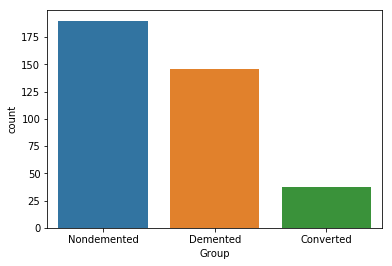

In [7]:
# Demented > ND at patients' initial visit
sns.countplot(x = 'Group', data = df)

In [8]:
# Group Demented = 0, Nondemented = 1
df['Group'] = df['Group'].replace(['Converted'],['Demented'])
df['Group_code'] = LabelEncoder().fit_transform(df['Group'])

df[['M/F', 'Gender_code', 'Group', 'Group_code']].head()

,M/F,Gender_code,Group,Group_code
0,M,1,Nondemented,1
1,M,1,Nondemented,1
2,M,1,Demented,0
3,M,1,Demented,0
4,M,1,Demented,0


In [9]:
# recoded data
display(df.info(), df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 17 columns):
Group          373 non-null object
Visit          373 non-null int64
MR Delay       373 non-null int64
M/F            373 non-null object
Age            373 non-null int64
EDUC           373 non-null int64
SES            354 non-null float64
MMSE           371 non-null float64
CDR            373 non-null float64
eTIV           373 non-null int64
nWBV           373 non-null float64
ASF            373 non-null float64
MMSE Group     373 non-null object
MMSE_code      373 non-null object
Gender_code    373 non-null int64
CDR_code       373 non-null int64
Group_code     373 non-null int64
dtypes: float64(5), int64(8), object(4)
memory usage: 49.6+ KB


None

Index(['Group', 'Visit', 'MR Delay', 'M/F', 'Age', 'EDUC', 'SES', 'MMSE',
       'CDR', 'eTIV', 'nWBV', 'ASF', 'MMSE Group', 'MMSE_code', 'Gender_code',
       'CDR_code', 'Group_code'],
      dtype='object')

## Data Exploration

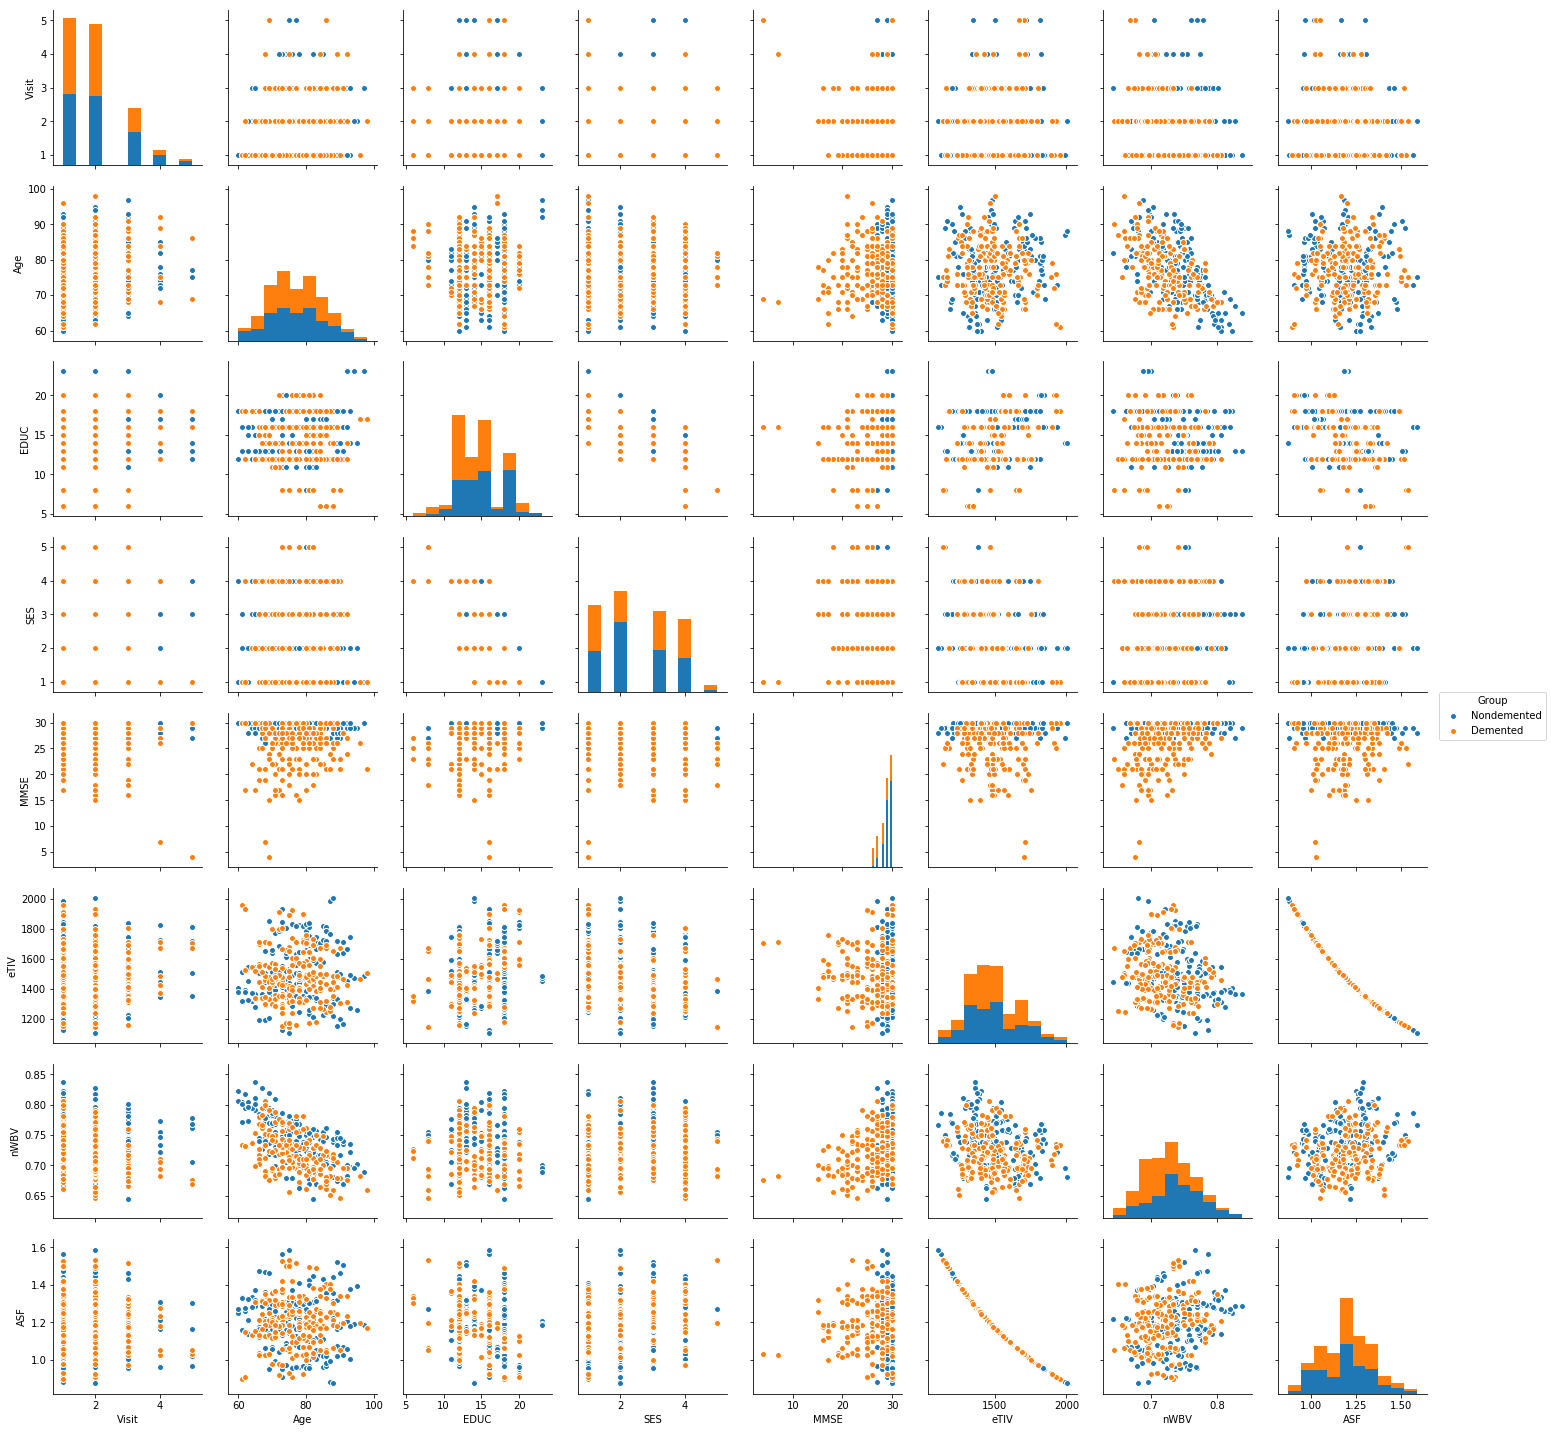

In [10]:
# multicolinearity exists
# related predictors: Age ~ -nWBV; eTIV ~ -nWBV; eTIV ~ -ASF
cols1 = ['Group', 'M/F', 'Visit', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV','ASF']
df1 = df[cols1]
sns.pairplot(df1, hue = 'Group')

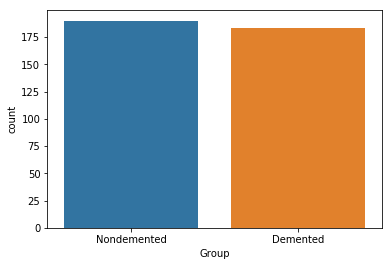

In [11]:
# Nondemented > Demented in this sample
sns.countplot(x = 'Group', data = df)

Text(0.5,0,'Age')

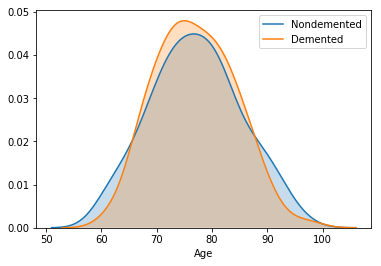

In [12]:
# Age
# Demented subjects has shorter range of age distrubition
# more demented people at age 67 - 88
sns.kdeplot(df.Age[df.Group=='Nondemented'], label='Nondemented', shade=True)
sns.kdeplot(df.Age[df.Group=='Demented'], label='Demented', shade=True)
plt.xlabel('Age')

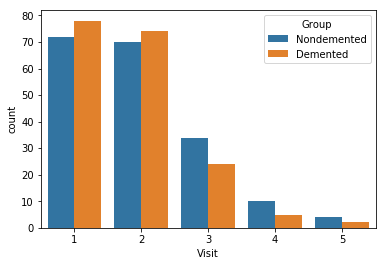

In [13]:
# Visit
# depend on this sample, this doesn't mean anything
sns.countplot(x = 'Visit', hue ='Group', data = df)

Text(0.5,0,'Years of Education')

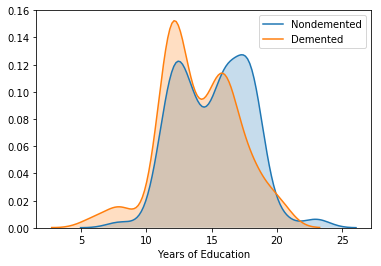

In [14]:
# Years of education
# More Demented people with less years of education
sns.kdeplot(df.EDUC[df.Group=='Nondemented'], label='Nondemented', shade=True)
sns.kdeplot(df.EDUC[df.Group=='Demented'], label='Demented', shade=True)
plt.xlabel('Years of Education')

C:\Users\ssun\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\ssun\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


Text(0.5,0,'SocialEconomics Status')

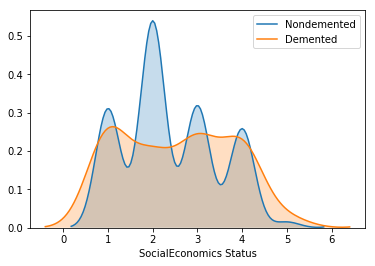

In [15]:
# SES (socialeconomics status)
# Demented population shows smoother SES
sns.kdeplot(df.SES[df.Group=='Nondemented'], label='Nondemented', shade=True)
sns.kdeplot(df.SES[df.Group=='Demented'], label='Demented', shade=True)
plt.xlabel('SocialEconomics Status')

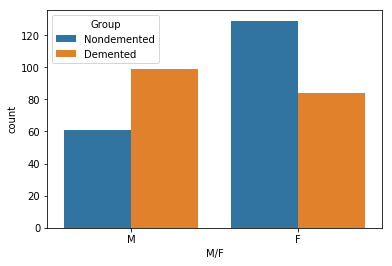

In [16]:
# Gender: M/F
# Demented male > ND male ; ND female > Demented female
# female less likely to be Demented than male
sns.countplot(x = 'M/F', hue = 'Group', data = df)

In [17]:
# recoded categorical varibles (Group_code)
# Group, M/F nominal
# CDR ordinal
df_rmna = df.dropna()
x_cols = ['Gender_code', 'Visit', 'Age', 'EDUC', 'SES', 'MMSE_code', 'CDR_code', 'eTIV', 'nWBV', 'ASF', 'MR Delay']
x_cols = ['Gender_code', 'Visit', 'Age', 'EDUC', 'SES', 'MMSE', 'CDR_code', 'eTIV', 'nWBV', 'ASF', 'MR Delay']
x_cols = ['Gender_code', 'Visit', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF', 'MR Delay']
# x_cols = ['Gender_code', 'Visit', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'MR Delay']

X = df_rmna[x_cols]
y = df_rmna['Group_code'].astype('category')

In [18]:
def scatterplot_2D(R, title, labels=None):
    """ Helper function to plot data points in 2D
        Requires (N, 2) numpy array shape
    """
    assert(R.shape[1] == 2)
    # class labels are turned into colors
    if labels is None:
        c = 'black'
    else:
        color_scale = np.linspace(0, 1, len(set(labels)))
        c = [plt.cm.Set1(color_scale[i]) for i in labels]

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.patch.set_facecolor('white')
    ax.scatter(R[...,0], R[...,1], color=c)
    ax.axis('square')
    ax.set_xlabel('R1')
    ax.set_ylabel('R2')
    fig.suptitle(title)
    plt.show()

[[ 3.91173804e-05  1.33243766e-03  2.49217004e-03  2.12072423e-04
  -5.89406572e-05  4.24955588e-04  3.53570132e-02 -6.14209630e-06
  -2.87161730e-05  9.99370634e-01]
 [ 1.61626063e-03  5.21108576e-05  6.25283893e-04  4.38559860e-03
  -1.68724080e-03 -6.20248515e-04  9.99361629e-01 -4.22874227e-05
  -7.68670108e-04 -3.53591754e-02]]
[93.  7.]


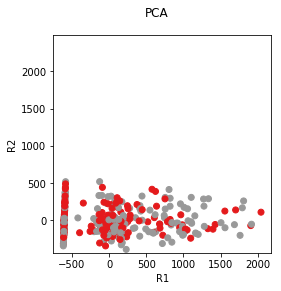

In [19]:
from sklearn.decomposition import PCA

# Dimension reduction
pca = PCA(n_components=2)
pca.fit(X)
print(pca.components_)
print(np.round(pca.explained_variance_ratio_ * 100))
R_PCA = pca.transform(X)
scatterplot_2D(R_PCA, 'PCA', y)

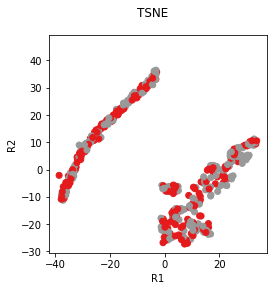

(354, 10)
(354, 2)


In [20]:
from sklearn.manifold import TSNE
R_TSNE = TSNE(n_components=2, perplexity=20).fit_transform(X)
scatterplot_2D(R_TSNE, 'TSNE', y)
print(X.shape)
print(R_TSNE.shape)

[[ 2.50435692e-02  8.52846406e-01  1.59492394e+00  1.35751164e-01
  -3.77288975e-02  2.71977201e-01  2.26338043e+01 -3.93095024e-03
  -1.83826232e-02  6.39660110e+02]
 [ 2.81499679e-01  9.06233344e-03  1.08599290e-01  7.63581245e-01
  -2.93799257e-01 -1.08105620e-01  1.74051689e+02 -7.36495174e-03
  -1.33878316e-01 -6.16961220e+00]]


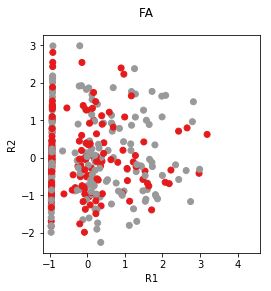

In [21]:
from sklearn.decomposition import FactorAnalysis
fa = FactorAnalysis(n_components=2)
fa.fit(X)
R_FA = fa.transform(X)
print(fa.components_)

scatterplot_2D(R_FA, 'FA', y)

Best parameter (CV score=0.585):
{'logistic__alpha': 0.0001, 'pca__n_components': 6}


C:\Users\ssun\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\ssun\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\ssun\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, *

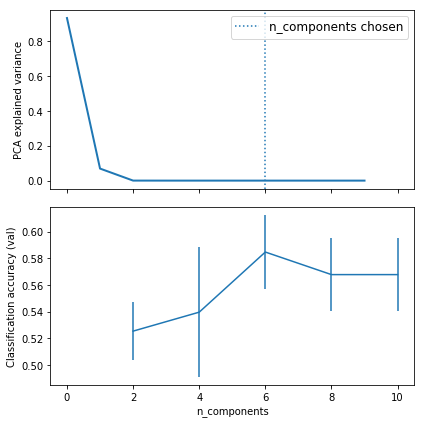

In [22]:
# Code source: Gaël Varoquaux
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
logistic = SGDClassifier(loss='log', penalty='l2', 
                         max_iter=10000, tol=1e-5, random_state=0)
pca = PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])


X_digits = X
y_digits = y

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': [2, 4, 6, 8, 10],
    'logistic__alpha': np.logspace(-4, 4, 5),
}
search = GridSearchCV(pipe, param_grid, iid=False, cv=5)
search.fit(X_digits, y_digits)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

# Plot the PCA spectrum
pca.fit(X_digits)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(pca.explained_variance_ratio_, linewidth=2)
ax0.set_ylabel('PCA explained variance')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')

plt.tight_layout()
plt.show()

## Modeling
- Logistic Regression
- Decision Tree
- Random Forest
- Gradient Boosting
- Naive Bayes
- KNN
- SVM

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# remove NA
df_rmna = df.dropna()

# X, y
x_cols = ['Gender_code', 'Visit', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'MR Delay']
# x_cols = ['Gender_code', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'MR Delay']

X = df_rmna[x_cols]
y = df_rmna['Group_code'].astype('category')

# Training & Test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

num_cols = ['Visit', 'Age', 'EDUC', 'SES', 'eTIV', 'nWBV', 'MMSE']
# num_cols = ['Age', 'EDUC', 'SES', 'eTIV', 'nWBV', 'MMSE']

# normalization
# training set
X_train_norm = StandardScaler().fit_transform(X_train[num_cols])
training_norm_col = pd.DataFrame(X_train_norm, index = X_train[num_cols].index, columns = X_train[num_cols].columns)
X_train.update(training_norm_col)

# test set
X_test_norm = StandardScaler().fit_transform(X_test[num_cols])
test_norm_col = pd.DataFrame(X_test_norm, index = X_test[num_cols].index, columns = X_test[num_cols].columns)
X_test.update(test_norm_col)

# whole set
X_norm = StandardScaler().fit_transform(X[num_cols])
norm_col = pd.DataFrame(X_norm, index = X[num_cols].index, columns = X[num_cols].columns)
X.update(norm_col)


X_train.shape, y_train.shape, X_test.shape, y_test.shape

C:\Users\ssun\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:5082: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[col] = expressions.where(mask, this, that)


((237, 9), (237,), (117, 9), (117,))

In [36]:
X_test.head()

,Gender_code,Visit,Age,EDUC,SES,MMSE,eTIV,nWBV,MR Delay
230,1,0.149565,0.800776,-1.230392,1.466054,0.414624,1.484825,-1.611983,766
48,0,0.149565,-0.776068,-0.897930,0.533835,0.693423,-0.705987,1.487111,609
298,0,0.149565,-0.513260,0.431916,0.533835,0.414624,-1.122469,1.182735,1707
189,1,-0.944131,-0.513260,1.096839,-0.398384,0.414624,0.366598,1.238076,0
62,0,-0.944131,0.275161,0.431916,-1.330603,0.414624,-0.101231,-0.698857,0


In [37]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import cross_val_score, KFold

lr = LogisticRegression(solver = 'lbfgs', max_iter=1000)

lr.fit(X_train, y_train)
y_predict = lr.predict(X_test)

se_lr = np.round(mean_squared_error(y_test, y_predict),2)
acc_lr = np.round(accuracy_score(y_test, y_predict),2)
print('MSE:', se_lr)
print('Accuracy:', acc_lr)

MSE: 0.18
Accuracy: 0.82


In [38]:
from sklearn.ensemble import ExtraTreesClassifier

# feature importance
# selected MMSE, nWBV, eTIV, Age, Gender
model = ExtraTreesClassifier()
model.fit(X_test, y_test)
# display the relative importance of each attribute
display(X_train.columns, model.feature_importances_)

Index(['Gender_code', 'Visit', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV',
       'MR Delay'],
      dtype='object')

array([0.07218421, 0.02111273, 0.09660794, 0.10827184, 0.08458084,
       0.28055286, 0.13071409, 0.15017638, 0.0557991 ])

MSE: 0.24
Accuracy: 0.76


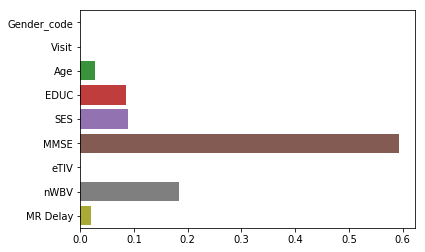

In [39]:
# Decision Tree 
from sklearn.tree import DecisionTreeClassifier

dtr = DecisionTreeClassifier(max_depth = 5, random_state = 0)
dtr.fit(X_train, y_train)
y_predict = dtr.predict(X_test)

se_dtr = np.round(mean_squared_error(y_test, y_predict),2)
acc_dtr = np.round(accuracy_score(y_test, y_predict),2)
print('MSE:', se_dtr)
print('Accuracy:', acc_dtr)

fea_ip = dtr.feature_importances_
sns.barplot(x = fea_ip, y = X.columns)

MSE: 0.24
Accuracy: 0.76


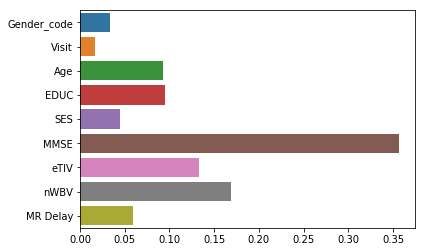

In [40]:
# Random Forest (bagging)
from sklearn.ensemble import RandomForestClassifier

rf= RandomForestClassifier(random_state = 123)
rf.fit(X_train, y_train)
y_predict = rf.predict(X_test)
mean_squared_error(y_test, y_predict)

se_rf = np.round(mean_squared_error(y_test, y_predict),2)
acc_rf = np.round(accuracy_score(y_test, y_predict),2)
print('MSE:', se_rf)
print('Accuracy:', acc_rf)

fea_ip = rf.feature_importances_
sns.barplot(x = fea_ip, y = X.columns)

MSE: 0.18
Accuracy: 0.82


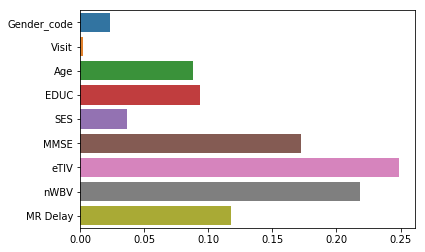

In [41]:
# Gradient Boosting (boosting)
# sequential improvement of models by training on their errors
# improves errors, one tree each step
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state = 0)
gb.fit(X_train, y_train)
y_predict = gb.predict(X_test)
mean_squared_error(y_test, y_predict)

se_gb = np.round(mean_squared_error(y_test, y_predict),2)
acc_gb = np.round(accuracy_score(y_test, y_predict),2)
print('MSE:', se_gb)
print('Accuracy:', acc_gb)

fea_ip = gb.feature_importances_
sns.barplot(x = fea_ip, y = X.columns)

In [42]:
# SVM
from sklearn.svm import SVC

clf = SVC(gamma='auto', random_state = 123)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)

se_clf = np.round(mean_squared_error(y_test, y_predict),2)
acc_clf = np.round(accuracy_score(y_test, y_predict),2)
print('MSE:', se_clf)
print('Accuracy:', acc_clf)

MSE: 0.44
Accuracy: 0.56


In [43]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

y_predict = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train).predict(X_test)

se_knn = np.round(mean_squared_error(y_test, y_predict),2)
acc_knn = np.round(accuracy_score(y_test, y_predict),2)
print('MSE:', se_knn)
print('Accuracy:', acc_knn)

MSE: 0.48
Accuracy: 0.52


In [75]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB

y_predict = GaussianNB().fit(X_train, y_train).predict(X_test)

se_nb = np.round(mean_squared_error(y_test, y_predict),2)
acc_nb = np.round(accuracy_score(y_test, y_predict),2)
print('MSE:', se_nb)
print('Accuracy:', acc_nb)

MSE: 0.2
Accuracy: 0.8


Text(0.5,1,'Accuracy')

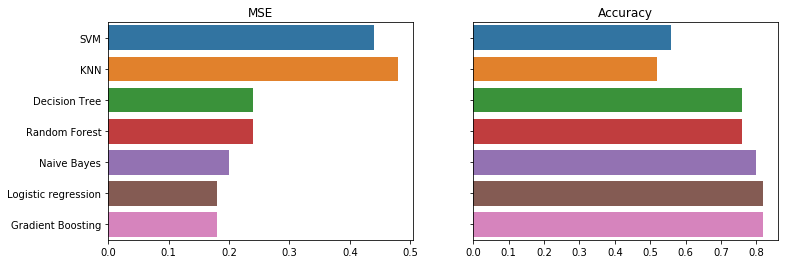

In [76]:
# visualize all methods
methods = ['SVM', 'KNN','Decision Tree', 'Random Forest', 'Naive Bayes', 'Logistic regression', 'Gradient Boosting']

se = [se_clf, se_knn, se_dtr, se_rf, se_nb, se_lr, se_gb]
acc = [acc_clf, acc_knn, acc_dtr, acc_rf, acc_nb, acc_lr, acc_gb]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
sns.barplot(x = se, y = methods, ax = ax1).set_title('MSE')
sns.barplot(x = acc, y = methods, ax = ax2).set_title('Accuracy')

LR: 0.747464 (0.078604)
KNN: 0.636413 (0.074390)
CART: 0.772464 (0.074130)
RF: 0.785326 (0.061792)
GB: 0.807246 (0.104632)
NB: 0.751630 (0.108395)
SVM: 0.591304 (0.106426)


[Text(0,0,'LR'),
 Text(0,0,'KNN'),
 Text(0,0,'CART'),
 Text(0,0,'RF'),
 Text(0,0,'GB'),
 Text(0,0,'NB'),
 Text(0,0,'SVM')]

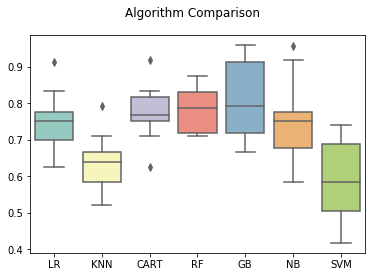

In [45]:
from sklearn.naive_bayes import GaussianNB

# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('GB', GradientBoostingClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = KFold(n_splits=10, random_state=123)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
sns.boxplot(names, results, palette="Set3")
ax.set_xticklabels(names)

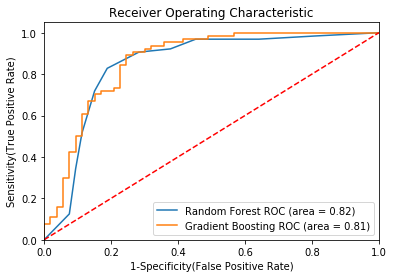

In [77]:
# ROC curve RandomForest and GradientBoosting 

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

plt.figure()

# Add the models to the list that you want to view on the ROC plot
models = [
{
    'label': 'Random Forest',
    'model': RandomForestClassifier(),
},
{
    'label': 'Gradient Boosting',
    'model': GradientBoostingClassifier(),
}
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(X_train, y_train) # train the model
    y_pred=model.predict(X_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = roc_auc_score(y_test, model.predict(X_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
    
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display

In [ ]:
## confusion matrix -- GB
from sklearn.metrics import confusion_matrix

y_predict = GradientBoostingClassifier(random_state = 0).fit(X_train, y_train).predict(X_test)

mat = confusion_matrix(y_test, y_predict)
sns.heatmap(mat.T, square=True,annot = True, fmt="d", cbar=False)
plt.xlabel('True Label')
plt.ylabel('Predicted Label')

### Hyperparameter Tuning

In [71]:
from sklearn.model_selection import GridSearchCV

param_test = {'max_depth':range(3,12,4), 'min_samples_split':range(20, 300, 20)}
gsearch = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.05, n_estimators=60, 
                                                              max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test, scoring='neg_mean_squared_error',n_jobs=4, iid=False, cv=5)
gsearch.fit(X_train, y_train)
gsearch.best_estimator_, gsearch.best_score_, gsearch.best_params_, gsearch.n_splits_ 

(GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.05, loss='deviance', max_depth=3,
               max_features='sqrt', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=20,
               min_weight_fraction_leaf=0.0, n_estimators=60,
               presort='auto', random_state=10, subsample=0.8, verbose=0,
               warm_start=False),
 -0.18636561007381675,
 {'max_depth': 3, 'min_samples_split': 20},
 5)

In [47]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.3, 1.0, 10)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring="neg_mean_squared_error")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

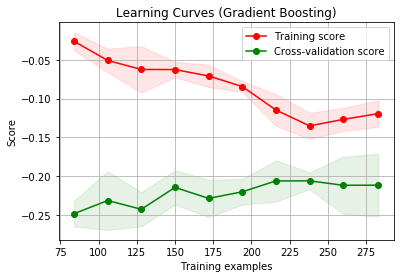

In [72]:
# test overfit
title = "Learning Curves (Gradient Boosting)"

# Create the CV iterator
cv_iterator = KFold(n_splits=5, shuffle=True, random_state=10)
model = GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.05, loss='deviance', max_depth=3,
               max_features='sqrt', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=20,
               min_weight_fraction_leaf=0.0, n_estimators=60,
               presort='auto', random_state=10, subsample=0.8, verbose=0,
               warm_start=False)
plot_learning_curve(model, title, X_norm, y, cv=cv_iterator, n_jobs=4)
plt.show()

In [78]:
gb = GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.05, loss='deviance', max_depth=3,
               max_features='sqrt', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=20,
               min_weight_fraction_leaf=0.0, n_estimators=60,
               presort='auto', random_state=10, subsample=0.8, verbose=0,
               warm_start=False)
gb.fit(X_train, y_train)
y_predict = gb.predict(X_test)
mean_squared_error(y_test, y_predict)

se_gb = np.round(mean_squared_error(y_test, y_predict),2)
acc_gb = np.round(accuracy_score(y_test, y_predict),2)
print('MSE:', se_gb)
print('Accuracy:', acc_gb)

MSE: 0.16
Accuracy: 0.84


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
import pprint

cv = StratifiedKFold(n_splits=5)
scores = cross_validate(gb, X, y, cv=cv,
                         scoring=('accuracy', 'f1_micro'),
                         return_train_score=True)
print('mean TRAIN accuracy: ', np.round(scores['train_accuracy'].mean(), 2))
print('mean TEST  accuracy: ', np.round(scores['test_accuracy'].mean(), 2))